# Analyze ZIP code–level COVID-19 case / demographic correlations

This notebook examines ZIP code–level COVID-19 case data for the following five cities:

- New York City
- Chicago
- Detroit
- Philadelphia
- Baltimore

For each, the notebook:

1. Loads the data 
2. Analyzes correlation 
3. Outputs data for charts and maps

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import json

## Load Census Data

The data loaded below has been pre-processed from ACS 5-year estimates for 2018, to cut down on the data file size.

In [2]:
census_data = pd.read_csv(
    "../data/processed/census/zip_census_data.csv",
    dtype={
        "zip_code": str, 
        "median_age": float, 
        "pct_below_poverty_level": float, 
        "average_household_size": float
    },
    na_values="-"
)

In [3]:
# Median income exists in the range of 2,500 to 250,000 and we need to clean up both sides
# for the regression model
def fix_median_income(median_income):
    if pd.isnull(median_income):
        return None
    elif median_income == "250,000+":
        return 250000
    elif median_income == "2,500-":
        return 2500
    else:
        return int(median_income)

In [4]:
census_data = census_data.assign(
    household_median_income = lambda df: df["household_median_income"].apply(lambda x: fix_median_income(x)),
    pct_over_age_65 = lambda df: df["age_65_and_over"] / df["total_population"],
    pct_white = lambda df: df["total_white_nonhispanic"] / df["total_population"],
    pct_minority = lambda df: 1 - df["pct_white"],
    pct_black = lambda df: df["total_black_nonhispanic"] / df["total_population"],
    pct_hispanic = lambda df: df["total_hispanic"] / df["total_population"],
)

In [5]:
census_data.set_index("zip_code").head().T

zip_code,06390,10001,10002,10003,10004
total_population,183,22924,74993,54682,3028
total_non_hispanic,179,19678,54603,50176,2916
total_white_nonhispanic,175,12182,16472,38521,1834
total_black_nonhispanic,0,1289,5249,2961,47
total_asian_alone,0,5731,30847,7366,899
total_black,4,1687,7645,3491,67
total_hispanic,4,3246,20390,4506,112
average_household_size,2.39562,1.75738,2.18401,1.70247,1.82545
pct_more_than_one_occupant_per_room,0,3.1,8.3,3.5,3.8
total_male,110,11671,36230,27503,1267


## Load City Data

By the end of this section, we will have one dataframe for each city:

- nyc_df
- chi_df
- balt_df
- phi_df
- det_df

#### New York City

*Note:* There are more than 1,800 cases without an assigned ZIP code in NYC.

In [6]:
nyc_df = (
    pd.read_csv(
        "../data/raw/nyc-health/tests-by-zcta-2020-05-04.csv",
        dtype = { "MODZCTA": str }
    )
    .merge(
        census_data,
        how = "left",
        left_on = "MODZCTA",
        right_on = "zip_code"
    )
    .assign(
        cases_per_1000 = lambda df: df["Positive"] / df["total_population"] * 1000,
    )
    .dropna(
        subset = [ "MODZCTA" ]
    )
)

nyc_df.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,zip_code,total_population,total_non_hispanic,total_white_nonhispanic,total_black_nonhispanic,total_asian_alone,...,pct_below_poverty_level,household_median_income,household_mean_income,pct_services,pct_over_age_65,pct_white,pct_minority,pct_black,pct_hispanic,cases_per_1000
1,10001,311,878,35.42,10001,22924.0,19678.0,12182.0,1289.0,5731.0,...,13.3,88526.0,196505,0.128273,0.148316,0.531408,0.468592,0.056229,0.141598,13.566568
2,10002,878,2069,42.44,10002,74993.0,54603.0,16472.0,5249.0,30847.0,...,27.7,35859.0,71841,0.275438,0.210820,0.219647,0.780353,0.069993,0.271892,11.707759
3,10003,399,1251,31.89,10003,54682.0,50176.0,38521.0,2961.0,7366.0,...,8.5,112131.0,306152,0.066278,0.117644,0.704455,0.295545,0.054149,0.082404,7.296734
4,10004,28,87,32.18,10004,3028.0,2916.0,1834.0,47.0,899.0,...,2.2,157645.0,305243,0.016378,0.075297,0.605680,0.394320,0.015522,0.036988,9.247028
5,10005,54,214,25.23,10005,8831.0,8223.0,6132.0,219.0,1497.0,...,9.5,173333.0,292722,0.023957,0.012683,0.694372,0.305628,0.024799,0.068848,6.114823


#### Chicago

In [7]:
def load_illinois():
    zip_dicts = []
    with open("../data/raw/idph/illinois-zip-codes-2020-05-04.json", "r") as f:
        data = json.loads(f.read())
        for zc in data["zip_values"]:
            zip_dict = {
                "zip_code": zc["zip"],
                "confirmed_cases": zc["confirmed_cases"],
                "total_tested": zc["total_tested"]
            }
            zip_dicts.append(zip_dict)
    return pd.DataFrame(zip_dicts)

ill_df = load_illinois()
ill_df.head()

,zip_code,confirmed_cases,total_tested
0,46324,7,75
1,46394,6,36
2,53142,13,87
3,54302,7,32
4,60002,56,391


In [8]:
chi_zips = gp.read_file("../data/raw/chi-shapefiles/geo_export_eb16a741-d078-4408-8a62-9eb56bb6cba3.shp")
chi_zips.head()

,objectid,shape_area,shape_len,zip,geometry
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917..."
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922..."
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909..."
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895..."


In [9]:
chi_df = (
    ill_df
    .loc[lambda x: x["zip_code"].isin(chi_zips["zip"])]
    .merge(
        census_data,
        how = "left",
        on = "zip_code",
    ).assign(
        cases_per_1000 = lambda df: df["confirmed_cases"] / df["total_population"] * 1000,
    )
)

chi_df.head()

,zip_code,confirmed_cases,total_tested,total_population,total_non_hispanic,total_white_nonhispanic,total_black_nonhispanic,total_asian_alone,total_black,total_hispanic,...,pct_below_poverty_level,household_median_income,household_mean_income,pct_services,pct_over_age_65,pct_white,pct_minority,pct_black,pct_hispanic,cases_per_1000
0,60601,57,379,14675,13401,9677,767,2641,818,1274,...,8.4,103243.0,186892,0.055037,0.141397,0.659421,0.340579,0.052266,0.086814,3.884157
1,60602,7,56,1244,1163,788,47,242,67,81,...,2.4,157125.0,253316,0.035484,0.004019,0.633441,0.366559,0.037781,0.065113,5.627010
2,60604,10,47,782,748,479,37,232,54,34,...,22.3,116250.0,376124,0.011952,0.118926,0.612532,0.387468,0.047315,0.043478,12.787724
3,60605,131,850,27519,25911,15781,4550,4431,5165,1608,...,9.6,111164.0,240969,0.076846,0.093354,0.573458,0.426542,0.165340,0.058432,4.760347
4,60606,31,236,3101,2906,2129,73,561,115,195,...,7.6,131477.0,278453,0.039231,0.138987,0.686553,0.313447,0.023541,0.062883,9.996775


In [10]:
assert chi_df["confirmed_cases"].isnull().sum() == 0
assert chi_df["total_population"].isnull().sum() == 0

#### Detroit

In [11]:
det_df = (
    pd.read_csv(
        "../data/raw/detroit-health/detroit-cases-2020-05-07.csv",
        dtype = { "zip_code": str }
    )
    .dropna(subset = [ "zip_code" ])
    .merge(
        census_data,
        how = "left",
        on = "zip_code",
    )
    .assign(
        cases_per_1000 = lambda df: df["confirmed_cases"] / df["total_population"] * 1000,
    )
)

det_df.head()

,zip_code,confirmed_cases,total_population,total_non_hispanic,total_white_nonhispanic,total_black_nonhispanic,total_asian_alone,total_black,total_hispanic,average_household_size,...,pct_below_poverty_level,household_median_income,household_mean_income,pct_services,pct_over_age_65,pct_white,pct_minority,pct_black,pct_hispanic,cases_per_1000
0,48219,772,48184,47754,2848,43882,236,44587,430,2.478443,...,32.9,33029.0,51314,0.421581,0.153101,0.059107,0.940893,0.910717,0.008924,16.021916
1,48223,297,24632,24296,2066,21446,111,22005,336,2.495243,...,30.7,35562.0,53956,0.449888,0.142254,0.083875,0.916125,0.870656,0.013641,12.057486
2,48228,627,55737,52594,8890,41902,37,42456,3143,2.880687,...,41.6,26269.0,39710,0.472901,0.100849,0.159499,0.840501,0.751781,0.056390,11.249260
3,48235,915,44753,44320,586,43129,45,43457,433,2.486242,...,31.1,31759.0,49848,0.429984,0.177575,0.013094,0.986906,0.963712,0.009675,20.445557
4,48227,584,41777,41582,669,39967,25,40662,195,2.704630,...,35.1,29250.0,43053,0.506074,0.141920,0.016014,0.983986,0.956675,0.004668,13.978984


#### Philadelphia

In [12]:
pa_df = gp.read_file("../data/raw/pa-health/zip-cases-2020-05-04.geojson")
phi_shp = gp.read_file("../data/raw/phi-shapefile/Zipcodes_Poly.shp")

In [13]:
pa_df.head()

,OBJECTID,ZIP_CODE,PO_NAME,Positive,Negative,Probable,Additional_Tracking,Positive_Redacted,Negative_Redacted,Shape__Area,Shape__Length,geometry
0,227,15521,Alum Bank,-1.0,8.0,0.0,None,None,None,0.009600,0.540144,"POLYGON ((-78.69882 40.16141, -78.69321 40.174..."
1,228,15522,Bedford,-1.0,51.0,0.0,None,None,None,0.051744,1.719056,"POLYGON ((-78.73625 39.72304, -78.73601 39.723..."
2,229,15530,Berlin,-1.0,43.0,-1.0,None,None,None,0.024916,1.187654,"POLYGON ((-78.76807 40.00961, -78.76774 40.009..."
3,230,15531,Boswell,0.0,22.0,0.0,None,None,None,0.016014,1.060947,"MULTIPOLYGON (((-79.01568 40.28520, -79.01565 ..."
4,231,15533,Breezewood,0.0,8.0,0.0,None,None,None,0.009377,1.000603,"POLYGON ((-78.21323 40.08838, -78.21233 40.088..."


In [14]:
phi_shp.head()

,OBJECTID,CODE,COD,Shape__Are,Shape__Len,geometry
0,1,19120,20,9.177970e+07,49921.544063,"POLYGON ((-75.11107 40.04682, -75.10943 40.045..."
1,2,19121,21,6.959879e+07,39534.887217,"POLYGON ((-75.19227 39.99463, -75.19205 39.994..."
2,3,19122,22,3.591632e+07,24124.645221,"POLYGON ((-75.15406 39.98601, -75.15328 39.985..."
3,4,19123,23,3.585175e+07,26421.728982,"POLYGON ((-75.15190 39.97056, -75.15150 39.970..."
4,5,19124,24,1.448080e+08,63658.770420,"POLYGON ((-75.09660 40.04249, -75.09281 40.039..."


In [15]:
phi_df = (
    pa_df.loc[lambda x: x["ZIP_CODE"].isin(phi_shp["CODE"])]
    .merge(
        census_data,
        how = "left",
        left_on = "ZIP_CODE",
        right_on = "zip_code",
    )
    .assign(
        cases_per_1000 = lambda df: df["Positive"] / df["total_population"] * 1000,
    )
)

phi_df.head()

,OBJECTID,ZIP_CODE,PO_NAME,Positive,Negative,Probable,Additional_Tracking,Positive_Redacted,Negative_Redacted,Shape__Area,...,pct_below_poverty_level,household_median_income,household_mean_income,pct_services,pct_over_age_65,pct_white,pct_minority,pct_black,pct_hispanic,cases_per_1000
0,1384,19102,Philadelphia,36.0,147.0,0.0,None,None,None,0.000047,...,14.3,90750.0,223116,0.046250,0.183715,0.725744,0.274256,0.044561,0.052461,7.291878
1,1385,19103,Philadelphia,150.0,421.0,0.0,None,None,None,0.000194,...,8.8,73611.0,219188,0.058501,0.215987,0.721252,0.278748,0.061894,0.056856,6.193484
2,1386,19104,Philadelphia,197.0,649.0,0.0,None,None,None,0.000860,...,45.3,25865.0,57260,0.230878,0.070207,0.345823,0.654177,0.418810,0.050929,3.627258
3,1387,19106,Philadelphia,34.0,230.0,0.0,None,None,None,0.000275,...,7.5,109393.0,228289,0.058237,0.176162,0.767273,0.232727,0.081051,0.064404,2.747475
4,1388,19107,Philadelphia,119.0,396.0,0.0,None,None,None,0.000145,...,23.3,53534.0,134247,0.131706,0.110616,0.554907,0.445093,0.079877,0.051329,8.688668


*There are no ZIP codes with either redacted data for positives or missing total_population:*

In [16]:
assert (
    phi_df
    [[
        "Positive",
        "total_population",
        "ZIP_CODE"
    ]]
    .isnull()
    .sum().sum()
) == 0

#### Baltimore

In [17]:
def load_maryland(): 
    zip_dicts = []
    with open("../data/raw/maryland/maryland-case-count-2020-05-04.json", "r") as f:
        data = json.loads(f.read())
        for zf in data["features"]:
            attrs = zf["attributes"]
            zip_dict = {
                "zip_code": attrs["ZIPCODE1"],
                "zip_name": attrs["ZIPName"],
                "case_count": attrs["ProtectedCount"]
            }
            zip_dicts.append(zip_dict)
    return pd.DataFrame(zip_dicts)

md_df = (
    load_maryland()
    .assign(case_count = lambda df: df["case_count"].fillna(0))
)

md_df.head()

,zip_code,zip_name,case_count
0,21230,Morrell Park,133.0
1,20626,Coltons Point,0.0
2,21703,Frederick,266.0
3,21207,Gwynn Oak,273.0
4,20675,Pomfret,0.0


In [18]:
balt_zips = gp.read_file("../data/raw/baltimore-shapefiles/ZIP_Codes.shp")
balt_zips.head()

,OBJECTID,ZIPCODE1,ZIPCODE2,ZIPNAME,zipcode_SH,geometry
0,60,21213,02451021213,Clifton,9.411134e+07,"POLYGON ((1432141.370 607325.721, 1432279.780 ..."
1,70,21205,02451021205,Baltimore,5.682149e+07,"POLYGON ((1439929.248 600706.435, 1440023.469 ..."
2,52,21227,02451021227,Halethorpe,3.044209e+04,"POLYGON ((1402910.236 582020.031, 1402976.835 ..."
3,41,21231,02451021231,Baltimore,2.283470e+07,"POLYGON ((1429913.376 593788.900, 1429926.602 ..."
4,51,21229,02451021229,Carroll,1.462700e+08,"POLYGON ((1406852.864 584336.370, 1406269.539 ..."


In [19]:
balt_df = (
    md_df.loc[lambda x: (
        x["zip_code"].isin(balt_zips["ZIPCODE1"]) & 
        ~x["zip_code"].isin([
            "21287", # Johns Hopkins University, no Census population
            "21251", # Morgan State University, closed
        ])
    )]
    .merge(
        census_data,
        how = "left",
        on = "zip_code",
    )
    .assign(
        cases_per_1000 = lambda df: df["case_count"] / df["total_population"] * 1000,
    )
)

balt_df.head()

,zip_code,zip_name,case_count,total_population,total_non_hispanic,total_white_nonhispanic,total_black_nonhispanic,total_asian_alone,total_black,total_hispanic,...,pct_below_poverty_level,household_median_income,household_mean_income,pct_services,pct_over_age_65,pct_white,pct_minority,pct_black,pct_hispanic,cases_per_1000
0,21230,Morrell Park,133.0,34947,32528,20830,9512,1207,9982,2419,...,14.0,81446.0,124801,0.148223,0.090909,0.596045,0.403955,0.272184,0.069219,3.805763
1,21207,Gwynn Oak,273.0,47687,46043,4348,39740,725,40581,1644,...,13.8,56719.0,82310,0.272607,0.191876,0.091178,0.908822,0.833351,0.034475,5.724831
2,21213,Clifton,128.0,31701,31178,2312,28051,79,28629,523,...,30.7,36136.0,55649,0.392523,0.111984,0.072931,0.927069,0.884862,0.016498,4.037728
3,21227,Halethorpe,163.0,33822,30203,22172,5048,1638,6005,3619,...,16.5,65395.0,84909,0.294882,0.126929,0.655550,0.344450,0.149252,0.107001,4.819348
4,21224,Highlandtown,354.0,50433,40671,28918,8098,1543,9255,9762,...,18.1,69615.0,97281,0.214084,0.101362,0.573394,0.426606,0.160569,0.193564,7.019214


## Examine correlations for each city

In [20]:
def correlate_census(df):
    return (
        df.corr()
        .loc[lambda df: df.index.str.contains("pct|median|average")]
        [["cases_per_1000"]]
        .assign(abs = lambda df: df["cases_per_1000"].abs())
        .sort_values("abs", ascending = False)
        .drop(columns = "abs")
        .round(3)
    )

#### New York City

In [21]:
correlate_census(nyc_df)

,cases_per_1000
pct_services,0.639
average_household_size,0.624
household_median_income,-0.519
pct_white,-0.518
pct_minority,0.518
pct_hispanic,0.411
pct_black,0.343
pct_more_than_one_occupant_per_room,0.247
pct_below_poverty_level,0.228
pct_over_age_65,0.097


In [22]:
(
    nyc_df
    .sort_values("cases_per_1000", ascending=False)
    .head(15)
    [["MODZCTA", "cases_per_1000", "average_household_size"]]
)

,MODZCTA,cases_per_1000,average_household_size
141,11369,39.861657,3.217181
142,11370,37.491542,3.171097
81,10475,35.410109,2.225844
75,10469,35.034520,3.174385
143,11372,34.651704,2.580632
67,10461,33.566378,2.602317
140,11368,33.302201,3.916339
82,11004,33.280819,2.767258
126,11239,33.071580,1.946211
166,11428,31.750225,3.402933


In [23]:
(
    nyc_df
    .sort_values("cases_per_1000", ascending=True)
    .head(10)
    [["MODZCTA", "cases_per_1000", "household_median_income", "pct_white"]]
)

,MODZCTA,cases_per_1000,household_median_income,pct_white
43,10280,4.049446,169844.0,0.704604
6,10006,6.079907,176250.0,0.632021
5,10005,6.114823,173333.0,0.694372
11,10012,6.193670,109037.0,0.697621
9,10010,6.937444,117923.0,0.639490
7,10007,6.977075,246813.0,0.719920
3,10003,7.296734,112131.0,0.704455
12,10013,7.558605,105442.0,0.523947
103,11215,7.611608,123583.0,0.669380
89,11109,7.691022,148590.0,0.621802


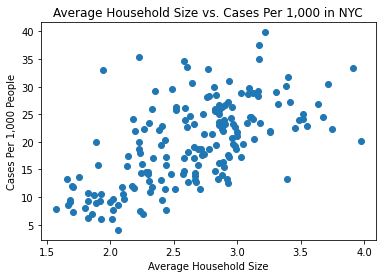

In [24]:
ax = plt.axes()
plt.scatter(
    nyc_df["average_household_size"],
    nyc_df["cases_per_1000"]
)
plt.title("Average Household Size vs. Cases Per 1,000 in NYC")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Average Household Size")
pass

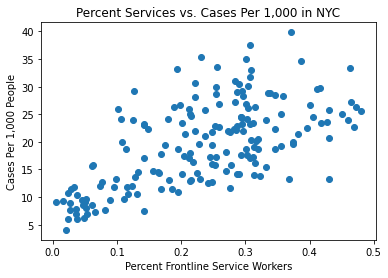

In [25]:
ax = plt.axes()
plt.scatter(
    nyc_df["pct_services"],
    nyc_df["cases_per_1000"]
)
plt.title("Percent Services vs. Cases Per 1,000 in NYC")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Frontline Service Workers")
pass

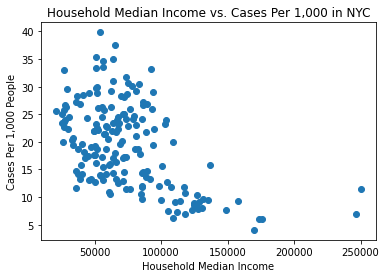

In [26]:
ax = plt.axes()
plt.scatter(
    nyc_df["household_median_income"],
    nyc_df["cases_per_1000"]
)
plt.title("Household Median Income vs. Cases Per 1,000 in NYC")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Household Median Income")
pass

#### Chicago

In [27]:
correlate_census(chi_df)

,cases_per_1000
pct_services,0.738
average_household_size,0.693
pct_white,-0.672
pct_minority,0.672
pct_more_than_one_occupant_per_room,0.633
household_median_income,-0.589
pct_below_poverty_level,0.583
pct_hispanic,0.486
pct_black,0.357
median_age,-0.069


In [28]:
(
    chi_df
    .sort_values("cases_per_1000", ascending=False)
    [["zip_code", "cases_per_1000", "pct_black", "pct_below_poverty_level"]]
    .head(10)
)

,zip_code,cases_per_1000,pct_black,pct_below_poverty_level
21,60623,17.748520,0.303539,33.4
35,60639,16.615663,0.129114,21.4
29,60632,14.367469,0.011039,19.9
40,60644,14.315057,0.895184,34.5
30,60633,13.984927,0.232072,21.4
41,60645,13.973854,0.170452,21.1
22,60624,13.136789,0.903728,44.2
7,60609,12.976665,0.243288,27.9
26,60629,12.901207,0.195485,18.3
2,60604,12.787724,0.047315,22.3


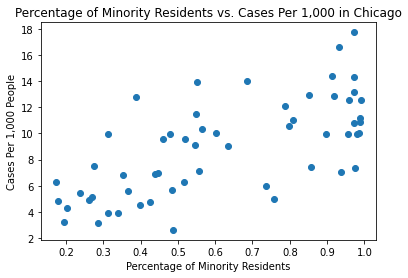

In [29]:
ax = plt.axes()
plt.scatter(
    chi_df["pct_minority"],
    chi_df["cases_per_1000"]
)
plt.title("Percentage of Minority Residents vs. Cases Per 1,000 in Chicago")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percentage of Minority Residents")
pass

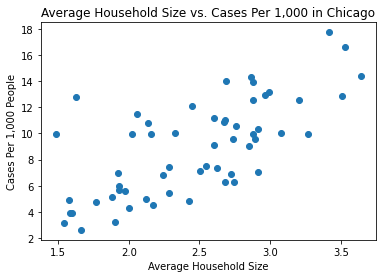

In [30]:
ax = plt.axes()
plt.scatter(
    chi_df["average_household_size"],
    chi_df["cases_per_1000"]
)
plt.title("Average Household Size vs. Cases Per 1,000 in Chicago")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Average Household Size")
pass

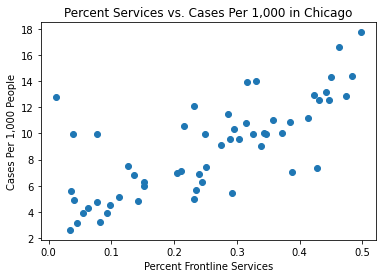

In [31]:
ax = plt.axes()
plt.scatter(
    chi_df["pct_services"],
    chi_df["cases_per_1000"]
)
plt.title("Percent Services vs. Cases Per 1,000 in Chicago")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Frontline Services")
pass

## Detroit Correlations

In [32]:
correlate_census(det_df)

,cases_per_1000
pct_black,0.702
pct_over_age_65,0.633
median_age,0.613
pct_more_than_one_occupant_per_room,-0.566
pct_white,-0.535
pct_minority,0.535
pct_hispanic,-0.503
average_household_size,-0.452
pct_below_poverty_level,-0.358
pct_services,-0.265


In [33]:
(
    det_df.sort_values("cases_per_1000", ascending=False)
    [["zip_code", "cases_per_1000", "pct_black"]]
    .head(10)
)

,zip_code,cases_per_1000,pct_black
3,48235,20.445557,0.963712
19,48207,18.464437,0.803721
22,48214,17.594613,0.823769
11,48208,17.181383,0.721401
0,48219,16.021916,0.910717
9,48206,15.369959,0.889870
5,48221,14.705531,0.900265
7,48204,14.434839,0.938917
20,48205,14.196095,0.936707
21,48213,14.082036,0.962711


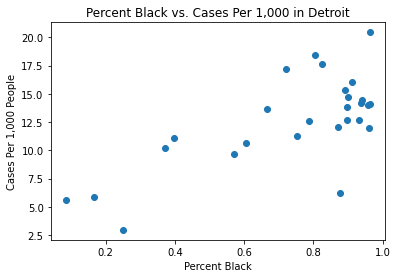

In [34]:
ax = plt.axes()
plt.scatter(
    det_df["pct_black"],
    det_df["cases_per_1000"]
)
plt.title("Percent Black vs. Cases Per 1,000 in Detroit")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Black")
pass

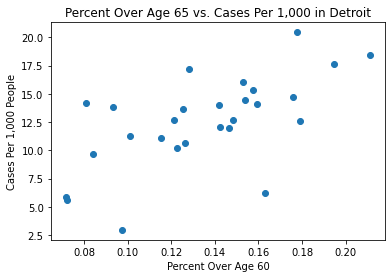

In [35]:
ax = plt.axes()
plt.scatter(
    det_df["pct_over_age_65"],
    det_df["cases_per_1000"]
)
plt.title("Percent Over Age 65 vs. Cases Per 1,000 in Detroit")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Over Age 60")
pass

## Philadelphia Correlations

In [36]:
correlate_census(phi_df)

,cases_per_1000
median_age,0.471
pct_over_age_65,0.437
pct_black,0.423
pct_minority,0.384
pct_white,-0.384
household_median_income,-0.283
pct_services,0.269
pct_hispanic,-0.156
pct_more_than_one_occupant_per_room,-0.133
average_household_size,0.089


In [37]:
(
    phi_df
    .sort_values("cases_per_1000", ascending=False)
    [["zip_code", "cases_per_1000", "pct_black"]]
    .head(10)
)

,zip_code,cases_per_1000,pct_black
18,19126,17.083780,0.815167
8,19115,14.965631,0.088837
28,19136,14.070206,0.153293
42,19150,12.849013,0.935710
24,19132,11.616350,0.905672
34,19142,11.476691,0.840037
9,19116,11.400092,0.059750
23,19131,11.029085,0.803900
43,19151,10.520287,0.870742
31,19139,10.274125,0.870136


In [38]:
(
    phi_df
    .sort_values("pct_white", ascending=False)
    [["zip_code", "cases_per_1000", "pct_white"]]
    .head(10)
)

,zip_code,cases_per_1000,pct_white
29,19137,2.947418,0.883754
19,19127,2.959553,0.812726
46,19154,7.357020,0.779727
20,19128,6.656399,0.768905
3,19106,2.747475,0.767273
7,19114,7.845979,0.755955
17,19125,5.228175,0.747305
0,19102,7.291878,0.725744
1,19103,6.193484,0.721252
8,19115,14.965631,0.681893


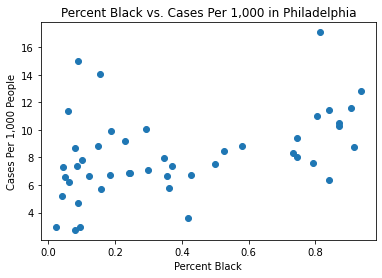

In [39]:
ax = plt.axes()
plt.scatter(
    phi_df["pct_black"],
    phi_df["cases_per_1000"]
)
plt.title("Percent Black vs. Cases Per 1,000 in Philadelphia")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Black")
pass

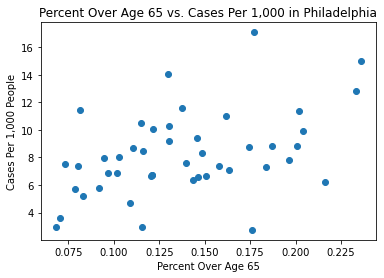

In [40]:
ax = plt.axes()
plt.scatter(
    phi_df["pct_over_age_65"],
    phi_df["cases_per_1000"]
)
plt.title("Percent Over Age 65 vs. Cases Per 1,000 in Philadelphia")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Over Age 65")
pass

## Baltimore Correlations

In [41]:
correlate_census(balt_df)

,cases_per_1000
median_age,0.434
pct_hispanic,0.328
pct_over_age_65,0.249
pct_minority,0.247
pct_white,-0.247
average_household_size,0.238
pct_black,0.197
pct_services,0.195
pct_more_than_one_occupant_per_room,0.137
household_median_income,-0.113


In [42]:
(
    balt_df
    .sort_values("cases_per_1000", ascending=False)
    [["zip_code", "cases_per_1000", "pct_over_age_65", "pct_black"]]
    .head(10)
)

,zip_code,cases_per_1000,pct_over_age_65,pct_black
7,21228,7.167640,0.192072,0.196539
24,21215,7.100328,0.194207,0.803090
4,21224,7.019214,0.101362,0.160569
10,21208,6.119481,0.256552,0.408578
1,21207,5.724831,0.191876,0.833351
26,21229,5.625052,0.135211,0.753505
27,21237,4.853728,0.144324,0.296441
3,21227,4.819348,0.126929,0.149252
8,21239,4.818039,0.150098,0.783766
14,21202,4.664446,0.084198,0.579819


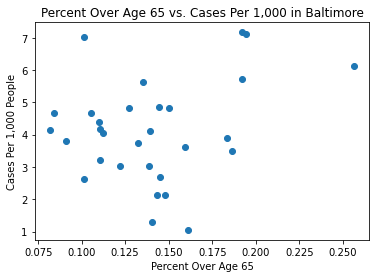

In [43]:
ax = plt.axes()
plt.scatter(
    balt_df["pct_over_age_65"],
    balt_df["cases_per_1000"]
)
plt.title("Percent Over Age 65 vs. Cases Per 1,000 in Baltimore")
plt.ylabel("Cases Per 1,000 People")
plt.xlabel("Percent Over Age 65")
pass

## Export Data for Mapping and Graphs

In [44]:
def export_data(df, city_name):
    (
        gp.GeoDataFrame(
            df
            [[
                "zip_code", "cases", "total_population", "cases_per_1000", "pct_black",
                "average_household_size", "pct_services", "household_median_income",
                "pct_over_age_65", "pct_below_poverty_level"
            ]],
            geometry = df["geometry"]
        )
        .to_file(f"../outputs/geojson/{city_name}_zips.geojson", driver='GeoJSON')
    )
    
    (
        df
        .drop(columns = [ "geometry" ])
        .to_csv(f"../outputs/csvs/{city_name}_zips.csv", index = None)
    )

In [45]:
# NYC
(
    gp
    .read_file("../data/raw/nyc-shapefiles/ZIP_CODE_040114.shp")
    .merge(
        nyc_df,
        left_on = "ZIPCODE",
        right_on = "zip_code"
    )
    .rename(
        columns = { "Positive": "cases" }
    )
    .pipe(export_data, "nyc")
)

In [46]:
# Chicago
(
    pd.merge(
        chi_zips,
        chi_df,
        right_on = "zip_code",
        left_on = "zip"
    )
    .rename(
        columns = {"confirmed_cases": "cases"}
    )
    .pipe(export_data, "chi")
)

In [47]:
# Detroit
(
    gp
    .read_file("../data/raw/detroit-shape/detroit-zips.geojson")
    .merge(
        det_df,
        left_on = "zipcode",
        right_on = "zip_code"
    )
    .rename(
        columns = { "confirmed_cases": "cases" }
    )
    .pipe(export_data, "det")
)

In [48]:
# Philadelphia 
(
    phi_df
    .rename(
        columns = { "Positive": "cases" }
    )
    .pipe(export_data, "phi")
)

In [49]:
# Baltimore
(
    pd.merge(
        balt_zips,
        balt_df,
        how = "left",
        left_on = "ZIPCODE1",
        right_on = "zip_code"
    )
    .dropna(subset=[ "total_population", "case_count" ])
    .rename(
        columns = {"case_count": "cases"}
    )
    .pipe(export_data, "balt")
)

----

----

----